(sec:ci)=
# Configuration interaction
## General theory

One of the conceptually (but not computationally) simplest way to solve the Schrödinger equation is to simply expand our many-body wavefunction on a n-electron basis set (not to be confused with the 1-electron basis functions used to expand orbitals):

\begin{equation}
| \Psi_{\text{CI}} \rangle = \sum_k c_k | \mathbf{k} \rangle 
\end{equation}

with energy:

```{math}
:label: eq:CIene
E_{\text{CI}} = \frac{\langle \Psi_{\text{CI}} | \hat{H} | \Psi_{\text{CI}} \rangle}{\langle \Psi_{\text{CI}} | \Psi_{\text{CI}} \rangle} 
```

We will discuss in the next section the choice of the basis, but in all cases, as the size of this basis set increases, the solution converges to the exact solution of the Schrödinger equation.

There is a redundancy in the parameters $c_k$ as multiplying them all by a constant does not change the energy. We thus add the constraint that the wavefunction should be normalised $\langle \Psi_{\text{CI}} | \Psi_{\text{CI}} \rangle = \sum_k c_k^2 = 1$. To minimize the wavefunction subject to this constraint, we write a Lagrangian:

\begin{equation}
L = E - \epsilon(\sum_k c_k^2 -1)
\end{equation}

To define our minimisation we set the gradient of our Lagrangian to 0 and obtain:

\begin{equation}
\frac{\mathrm{d}L}{\mathrm{d} c_k} =  \sum_i \langle \mathbf{i} | \hat{H} | \mathbf{k} \rangle c_i - \epsilon c_k + cc.= 0
\end{equation}

with $cc.$ the complex conjugate of the expression. This can finally be recast in the familiar form:

\begin{equation}
\mathbf{H} \mathbf{c} = \epsilon \mathbf{c}
\end{equation}

showing that minimising the the energy in Eq. {eq}`eq:CIene` is equivalent to diagonalising the Hamiltonian matrix in our chosen basis, with the eigenvalues being the energies of all possible states in the system. The ground state simply corresponds to the lowest eigenvalue.

## The $N$-electron basis

There are in principle an infinite number of possible $N$-electron basis to choose from, but we ideally want the expansion to converge quickly (compact expansion) and the functions to be easily manipulatable to efficiently compute the Hamiltonian elements. Naturally, these two criteria often go opposite.

As electron correlation depends on the distance between electrons, it would be natural to use functions that depend explicitely on this distance, the same way as our gaussian or Slater 1-electron basis depends explicitely on the distance between electron and nuclei. Wavefunction having this properties are typically called explicitly correlated wavefunctions, but this interelectronic distance makes the calculation of integrals very difficult as it couples multiple electrons together.

We often drop this explicit dependence and instead use a wavefunction that is simply formed from products of one-electron functions, i.e., product of orbitals. The simplest of these basis functions is the Hartree product, but since we know the wavefunction should be antisymmetric with respect to the exchange of two electrons, we instead use the antisymmetrised version of the Hartree product: Slater determinants (SDs). As each SD represents a different electronic configuration, the resulting method is called configuration interaction (CI). As discussed in the previous sections, this basis of SD constitutes a complete basis within a specified one-electron basis set, and thus the solution obtained by minimizing the energy of this wavefunction is the exact ground state within that one-electron basis.

In some codes, configuration state functions (CSF) are used instead of SDs. CSF are fixed linear combinations of SDs but with the attractive properties that they are also eigenfunctions of the $\hat{S}^2$ spin operator. This spin constraints means that the resulting wavefunction will always be spin-adapted and also that CSF are less numerous than Slater determinants, which has advantages on a computational standpoint. However, SDs can be expressed as ordered "strings" of $\alpha$ and $\beta$ creating operators, and this separation of $\alpha$ and $\beta$ electrons allows for efficient computer implementations, outweighing the benefits of the slightly smaller expansion of CSF.

Having chosen SDs as our basis functions, we now need an efficient way to create our expansion, i.e., a direct link between a given index in our expansion and the corresponding occupation of the SDs. This link should work both ways, matching a given occupation to the corresponding index in the expansion. A common choice is the so-called lexical ordering or the reverse lexical ordering. The details are beyond the scope of this page, but fortunately, the MultiPsi package provides the tools to do this.

Let's start by initialising a calculation for O$_2$. We will first run a Hartree-Fock calculation to generate starting orbitals. The ground state of this molecule is a triplet, so we will use unrestricted HF. Note that full CI is exact and does not depend on the actual shape of the orbitals, so we could have run a singlet calculation instead without changing the result.

In [27]:
import veloxchem as vlx
import multipsi as mtp
import numpy as np
O2_xyz="""2
O2                                                                                                                         
O    0.000000000000        0.000000000000       -0.600000000000 
O    0.000000000000        0.000000000000        0.600000000000 
"""

molecule = vlx.Molecule.from_xyz_string(O2_xyz)
molecule.set_multiplicity(3)
basis = vlx.MolecularBasis.read(molecule,"STO-3G")

scfdrv = vlx.ScfUnrestrictedDriver()
scfdrv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Unrestricted Hartree-Fock                                       
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

The next step is to define our CI using the MultiPsi.OrbSpace object. The meaning of this step will become more clear when we discuss truncated CI and active spaces. Now we simply define a full CI by using the FCI keyword. Then we use the CIExpansion class to create the tools necessary to handle the CI expansion.

In [3]:
space=mtp.OrbSpace(molecule,scfdrv.mol_orbs)
space.FCI()
expansion=mtp.CIExpansion(space)
print(expansion)


          CI expansion:
          -------------
Number of determinants:      1200




Printing the expansion shows the number of Slater determinants. As you can see, the number is already fairly large. This is not an issue in a real calculation, but for testing purposes, we will restrict this number a bit. For this, we will simply exclude the 1s and 2s of the oxygen from the calculation. The remaining orbitals define a so-called complete active space (CAS). There are 8 electrons and 6 orbitals remaining, so we will define it as a CAS(8,6): 

In [28]:
space.CAS(8,6)
expansion=mtp.CIExpansion(space)
print(expansion)


          CI expansion:
          -------------
Number of determinants:      120




This number is much more manageable.

Now we can look at the determinants themselves. The easiest way is to use the generator detlist() of the expansion class in a python for loop, which as the name implies will provide the determinants in a predefined order, here in reverse lexical ordering. By printing the determinant directly, we get the string representation, with a character for each orbital in the system. '2' indicates that the orbital is doubly occupied, 'a' and 'b' indicates an $\alpha$ or $\beta$ electron, and '0' an empty orbital. The determinant also provides a python list of the orbitals containing a $\alpha$ or $\beta$ electron.

In [5]:
for det in expansion.detlist():
    print(det,det.occ_alpha(),det.occ_beta())

222aa0 [0, 1, 2, 3, 4] [0, 1, 2]
22a2a0 [0, 1, 2, 3, 4] [0, 1, 3]
2a22a0 [0, 1, 2, 3, 4] [0, 2, 3]
a222a0 [0, 1, 2, 3, 4] [1, 2, 3]
22aa20 [0, 1, 2, 3, 4] [0, 1, 4]
2a2a20 [0, 1, 2, 3, 4] [0, 2, 4]
a22a20 [0, 1, 2, 3, 4] [1, 2, 4]
2aa220 [0, 1, 2, 3, 4] [0, 3, 4]
a2a220 [0, 1, 2, 3, 4] [1, 3, 4]
aa2220 [0, 1, 2, 3, 4] [2, 3, 4]
22aaab [0, 1, 2, 3, 4] [0, 1, 5]
2a2aab [0, 1, 2, 3, 4] [0, 2, 5]
a22aab [0, 1, 2, 3, 4] [1, 2, 5]
2aa2ab [0, 1, 2, 3, 4] [0, 3, 5]
a2a2ab [0, 1, 2, 3, 4] [1, 3, 5]
aa22ab [0, 1, 2, 3, 4] [2, 3, 5]
2aaa2b [0, 1, 2, 3, 4] [0, 4, 5]
a2aa2b [0, 1, 2, 3, 4] [1, 4, 5]
aa2a2b [0, 1, 2, 3, 4] [2, 4, 5]
aaa22b [0, 1, 2, 3, 4] [3, 4, 5]
222a0a [0, 1, 2, 3, 5] [0, 1, 2]
22a20a [0, 1, 2, 3, 5] [0, 1, 3]
2a220a [0, 1, 2, 3, 5] [0, 2, 3]
a2220a [0, 1, 2, 3, 5] [1, 2, 3]
22aaba [0, 1, 2, 3, 5] [0, 1, 4]
2a2aba [0, 1, 2, 3, 5] [0, 2, 4]
a22aba [0, 1, 2, 3, 5] [1, 2, 4]
2aa2ba [0, 1, 2, 3, 5] [0, 3, 4]
a2a2ba [0, 1, 2, 3, 5] [1, 3, 4]
aa22ba [0, 1, 2, 3, 5] [2, 3, 4]
22aa02 [0,

## The CI Hamiltonian

Now that we have the list of determinants, we only need to form the CI Hamiltonian. For this, we need to be able to calculate the matrix elements.

MultiPsi also provides a function to do that. For this we need to initialise the CIOperator class, which computes the  integrals in the molecular basis and provides several functions to use them in a CI calculation.

In [6]:
CIham=mtp.CIOperator(molecule,basis,expansion) #Contains integrals and functions using them
CIham.compute_ints()

We can now compute the Hamiltonian. The easiest is to simply do a double loop over SD and then computing the matrix element using the Hij function of CIOperator:

In [7]:
Ham=np.zeros((expansion.nDet,expansion.nDet))
for i,idet in enumerate(expansion.detlist()):
    for j,jdet in enumerate(expansion.detlist()):
        Ham[i,j]=CIham.Hij(idet,jdet)

If we diagonalise this hamiltonian, we now obtain all the energies of the system, both ground and excited states:

In [8]:
w,v=np.linalg.eigh(Ham)
print(w)

[-147.72142572 -147.49304169 -147.49304169 -147.48807552 -147.3873587
 -147.3873587  -147.30200524 -147.27544175 -147.27544175 -147.14731015
 -147.14731015 -147.08159064 -147.08159064 -147.07878348 -147.07001287
 -147.06034613 -147.06034613 -147.00846109 -147.00846109 -146.9956644
 -146.9956644  -146.97297098 -146.97297098 -146.94721038 -146.93555355
 -146.93555355 -146.92638432 -146.8851956  -146.8851956  -146.88031319
 -146.83656167 -146.83656167 -146.8194181  -146.74951724 -146.74951724
 -146.7444825  -146.7444825  -146.73931587 -146.7380768  -146.7380768
 -146.71308896 -146.71308896 -146.69767334 -146.69767334 -146.65702461
 -146.63644115 -146.63644115 -146.56808066 -146.53474692 -146.49721331
 -146.49721331 -146.49222219 -146.48988297 -146.48988297 -146.43557548
 -146.43557548 -146.43157041 -146.41342432 -146.39421472 -146.36844193
 -146.36844193 -146.34140472 -146.33447137 -146.33447137 -146.27735346
 -146.27735346 -146.27295048 -146.26022031 -146.22089316 -146.21143536
 -146.202

Note how the first (and lowest) energy is indeed lower than the one found at the Hartree-Fock level. This comes both from electron correlation and from using the correct triplet multiplicity. However, it is important to note that some of the states obtained here are not actually triplet but have a higher multiplicity. As we discussed in the previous section, the basis of Slater Determinant is not spin-adapted.  The only constraint in our expansion is the value of $m_s$, here $m_s = 1$, meaning we have two more $\alpha$ electron than $\beta$. This excludes singlet (which can only have $m_s=0$) but does not exclude some quintets or higher.

We can also print the first eigenvector:

In [9]:
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})
print(v[:,0])

[-0.970 -0.000 -0.000 -0.000 -0.000 -0.000 0.000 -0.000 0.179 -0.000
 -0.000 -0.000 -0.000 0.000 0.000 0.071 0.071 0.000 -0.000 -0.000 0.000
 0.000 -0.000 0.000 -0.000 -0.000 -0.000 0.000 -0.000 0.003 0.000 -0.000
 -0.000 -0.000 -0.001 -0.000 -0.000 0.000 -0.000 -0.000 0.000 0.000 -0.000
 0.000 -0.000 0.000 -0.000 0.003 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000
 -0.000 -0.000 -0.000 -0.001 -0.000 -0.000 0.000 -0.000 0.000 -0.000 0.000
 0.007 0.000 0.000 -0.000 -0.000 0.019 0.000 0.000 -0.000 -0.000 -0.000
 -0.000 0.000 -0.000 0.000 -0.000 0.000 0.000 -0.075 0.075 -0.000 0.000
 -0.000 0.000 0.000 0.000 0.061 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.033 0.000 -0.000 -0.007 -0.000 0.000 0.000 0.000 0.000 -0.000 0.000
 -0.000 0.000 0.019 -0.000 0.000 0.000 -0.000 0.000 0.000 0.000]


One can see that the largest coefficient is the first one, corresponding to the '222aa0' determinant, which intuitively is indeed the expected ground state configuration.

You may be curious as to what happens in the Hij function, that is, how we compute the $\langle i | H | j \rangle $ matrix elements. The answer to this is the Slater-Condon rules, see the section on [Slater Determinants](sec:slater). This rules define the matrix elements in terms of molecular integrals, depending on the difference in occupation between the 2 determinants. The difference in occupation is easily formulated in terms of excitations, with different rules depending on if $|j \rangle$ is singly or doubly excited compared to $|i \rangle$. Any higher excitation will simply lead to 0.

These rules are relatively easy to derive, both in standard and second quantization formulation. The idea is that the Hamiltonian has to "reconcile" the excitations. Being a two-electron operator, the Hamiltonian can reconcile at most two excitations.

First we need to obtain the necessary integrals. Those are the standard 1 and 2 electron integrals but in the molecular orbital basis as the expressions are simpler in this basis. Since we are leaving some occupied orbitals outside of the CI space (the s orbitals), also called inactive orbitals, we also need to include their interaction with the electrons in our CI. This is done by replacing the 1 electron integrals by the inactive Fock matrix defined as:

\begin{equation}
F^I_{pq} = h_{pq} + \sum_{i \in \mathrm{inactive}} 2 (ii|pq) - (ip|iq) 
\end{equation}

To compute the total energy, we also need to include the inactive energy, which is simply the energy of the inactive electrons and the nuclear-nuclear repulsion term.

\begin{equation}
E^I = V_{NN} + \sum_{i \in \mathrm{inactive}} 2 ( h_{ii} + F^I_{ii} )
\end{equation}
or using the AO matrices

\begin{equation}
E^I = V_{NN} + \sum_{pq} D^I_{pq} ( h_{pq} + F^I_{pq} )
\end{equation}
with the inactive density defined from the MO coefficients $C^i_p$:

\begin{equation}
D^I_{pq}= \sum_{i \in \mathrm{inactive}} C^i_pC^i_q
\end{equation}


In [10]:
nIn=space.nOcc #Number of inactive orbitals
nAct=space.nAct #Number of active orbitals
nbas=space.norb #Total number of orbitals

############################
## Get integrals and V_NN ##
############################
V_nuc = molecule.nuclear_repulsion_energy()

# one-electron Hamiltonian
kinetic_drv = vlx.KineticEnergyIntegralsDriver()
T = kinetic_drv.compute(molecule, basis).to_numpy()

nucpot_drv = vlx.NuclearPotentialIntegralsDriver()
V = -nucpot_drv.compute(molecule, basis).to_numpy()

h = T + V 

# two-electron Hamiltonian
eri_drv = vlx.ElectronRepulsionIntegralsDriver()
g = np.zeros((nbas, nbas, nbas, nbas))
eri_drv.compute_in_mem(molecule, basis, g)

#################################
## Compute the needed matrices ##
#################################

C = scfdrv.mol_orbs.alpha_to_numpy()
Cact=C[:, nIn:nIn+nAct] #Active MOs
    
# Compute the inactive Fock matrix
Din = np.einsum('ik,jk->ij', C[:, :nIn], C[:, :nIn]) #inactive density
Jin = np.einsum('ijkl,kl->ij', g, Din)
Kin = np.einsum('ilkj,kl->ij', g, Din)
Fin = h + 2*Jin - Kin
    
# Transform to MO basis
Ftu = np.einsum("pq,qu, pt->tu", Fin   , Cact, Cact)
    
#Inactive energy:
Ein = np.einsum('ij,ij->', h + Fin, Din) + V_nuc

#Compute the MO 2-electron integrals
pqrw = np.einsum("pqrs,sw->pqrw", g   , Cact)
pqvw = np.einsum("pqrw,rv->pqvw", pqrw, Cact)
puvw = np.einsum("pqvw,qu->puvw", pqvw, Cact)
tuvw = np.einsum("puvw,pt->tuvw", puvw, Cact)

These integrals are also provided directly by CIham if needed:

In [11]:
assert abs(Ein - CIham.inEne)<1.0e-8
np.testing.assert_almost_equal(Ftu, CIham.Ftu)
np.testing.assert_almost_equal(tuvw, CIham.tuvw)

We can now implement the Slater Condon rules:

In [12]:
def SC_diag(occa, occb):
    '''
    The energy of a given SD, as a function of its list of occupied orbitals
    '''
    Hij=Ein #Inactive energy (inc. nuclear repulsion)
    for i in occa:
        Hij+=Ftu[i,i] #1-e term = inactive Fock matrix
        for j in occa:
            if i<j:
                Hij+=tuvw[i,i,j,j]-tuvw[i,j,j,i] #Coulomb-Exchange
        for j in occb:
            Hij+=tuvw[i,i,j,j]
    for i in occb:
        Hij+=Ftu[i,i]
        for j in occb:
            if i<j:
                Hij+=tuvw[i,i,j,j]-tuvw[i,j,j,i]
    return Hij
def SC_1exc(i,a,ss_occ, os_occ):
    '''
    Slater-Condon between a SD and a singly excited, depending on the excited orbitals (i,a)
    and the same-spin (compared to spin of the excitated electron) and opposite-spin occupation
    '''
    Hij=Ftu[i,a]
    for k in ss_occ:
        Hij+=tuvw[i,a,k,k]-tuvw[i,k,k,a]
    for k in os_occ:
        Hij+=tuvw[i,a,k,k]
    return Hij
def SC_ss1exc(i,a,j,b):
    '''
    Slater-Condon between a SD and a doubly excited determinant,
    with both excited electrons having the same spin
    '''
    return tuvw[i,a,j,b]-tuvw[i,b,j,a]
def SC_os1exc(i,a,j,b):
    '''
    Slater-Condon between a SD and a doubly excited determinant,
    with the excited electrons having opposite spin
    '''
    return tuvw[i,a,j,b]

The difficult part is to make sure that the occupations of the Slater determinants are brought to maximum concordance. The expansion produced by lexical ordering may not have this property, but one can switch electrons until we reach this maximum concordance, introducing a negative phase factor at each electron exchange. Again, MultiPsi provides a convenient way to achieve this. The idea is to explicitely create the singly excitated determinant (or doubly excited by applying the operation twice) and then keep track of the number of exchanges to bring it to natural ordering. The excite_alpha and excite_beta functions do this, providing both the excited determinant and the phase factor. The index() function of the determinants then provides the index of the given determinant in the expansion, in order to associate the energy to the correct position in the Hamiltonian.

With this new tools and our Slater-Condon functions, we can now rewrite the above code. We replace the double loop by a simple loop and then an explicit construction of all singly and doubly excited determinants. The resulting code looks more complex but is relatively easy to follow.

In [13]:
Ham=np.zeros((expansion.nDet,expansion.nDet))
for idet,det in enumerate(expansion.detlist()):
    #Diagonal term
    Ham[idet,idet]=SC_diag(det.occ_alpha(),det.occ_beta())
    #Single excitations alpha
    for i in det.occ_alpha():
        for a in det.unocc_alpha():
            phase,excdet=det.excite_alpha(i,a)
            Ham[idet,excdet.index()]=phase*SC_1exc(i,a,det.occ_alpha(),det.occ_beta())
            #alpha-alpha excitation
            for j in det.occ_alpha():
                if i>=j:
                    continue
                for b in det.unocc_alpha():
                    if a>=b:
                        continue
                    phase2,exc2det=excdet.excite_alpha(j,b)
                    Ham[idet,exc2det.index()]=phase*phase2*SC_ss1exc(i,a,j,b)
            #alpha-beta excitation
            for j in det.occ_beta():
                for b in det.unocc_beta():
                    phase2,exc2det=excdet.excite_beta(j,b)
                    Ham[idet,exc2det.index()]=phase*phase2*SC_os1exc(i,a,j,b)
    #Single excitations beta
    for i in det.occ_beta():
        for a in det.unocc_beta():
            phase,excdet=det.excite_beta(i,a)
            Ham[idet,excdet.index()]=phase*SC_1exc(i,a,det.occ_beta(),det.occ_alpha())
            #beta-beta excitation
            for j in det.occ_beta():
                if i>=j:
                    continue
                for b in det.unocc_beta():
                    if a>=b:
                        continue
                    phase2,exc2det=excdet.excite_beta(j,b)
                    Ham[idet,exc2det.index()]=phase*phase2*SC_ss1exc(i,a,j,b) 

The advantage of this loop structure is that we only compute the non-zero elements. It can be easily verified that we obtain the same result:

In [14]:
w,v=np.linalg.eigh(Ham)
print(w[0:3])

[-147.721 -147.493 -147.493]


## Direct CI

As we saw, the number of SDs $N_{\mathrm{SD}}$ grows extremely rapidly with the size of the system. The Hamiltonian matrix grows even faster, with size $N_{\mathrm{SD}}^2$. For example, for a singlet with 6 electron in 6 orbitals, the number of SD is 210, growing to 31 878 for 10 electrons in 10 orbitals and 82 824 885 for 16 in 16. At this scale, the Hamiltonian matrix would take nearly 7000 TB of storage on a computer. Most of the matrix elements are zero, but even using sparse storage, the memory footprint is enormous.

Fortunately, we are rarely if ever interested in the entire list of excited states, usually only the ground state and/or a couple of excited states. In this case, one can replace the diagonalisation of the Hamiltonian by an iterative process where we progressively optimise a couple of states. In this case, we do not need to store the entire Hamiltonian matrix, but we only need to know its effect on a vector, the so-called $\sigma$ vector:

\begin{equation}
\mathbf{\sigma} = \mathbf{H} \mathbf{c}
\end{equation}

In order to solve $ \mathbf{H} \mathbf{c} = \epsilon \mathbf{c} $, we can use a method similar to the conjugate gradient optimisation, which in this context is called the Davidson method. At each iteration, a new trial vector is constructed according to:

(eq:cidav)=
\begin{equation}
\label{cidav}
\mathbf{c_{\mathrm{dav}}} = (\mathbf{H_0} - \epsilon)^{-1} \mathbf{r}
\end{equation}
with $\mathbf{H_0}$ the preconditioner, typically the diagonal of the Hamiltonian and $\mathbf{r}$ the residual vector defined as

\begin{equation}
\mathbf{r} = (\mathbf{H} - \epsilon) \mathbf{c} = \mathbf{\sigma} - \epsilon \mathbf{c}
\end{equation}

To compute the improved CI vector, one typically creates and diagonalise a small Hamiltonian matrix in the basis of $\mathbf{c}$ and $\mathbf{c_{\mathrm{dav}}}$, sometimes including also the vectors at previous iterations to improve convergence.

Thus, only quantities with sizes equal to the number of SD are needed, and expansion up to up to hundreds of millions of determinant can be computed on a standard computer.

The code we had to compute the Hamiltonian can be trivially modified to compute the sigma vector:

In [15]:
def sigma(vector):
    result=np.zeros(expansion.nDet)
    for idet,det in enumerate(expansion.detlist()):
        #Diagonal term
        result[idet]+=SC_diag(det.occ_alpha(),det.occ_beta())*vector[idet]
        #Single excitations alpha
        for i in det.occ_alpha():
            for a in det.unocc_alpha():
                phase,excdet=det.excite_alpha(i,a)
                result[excdet.index()]+=phase*SC_1exc(i,a,det.occ_alpha(),det.occ_beta())*vector[idet]
                #alpha-alpha excitation
                for j in det.occ_alpha():
                    if i>=j:
                        continue
                    for b in det.unocc_alpha():
                        if a>=b:
                            continue
                        phase2,exc2det=excdet.excite_alpha(j,b)
                        result[exc2det.index()]+=phase*phase2*SC_ss1exc(i,a,j,b)*vector[idet]
                #alpha-beta excitation
                for j in det.occ_beta():
                    for b in det.unocc_beta():
                        phase2,exc2det=excdet.excite_beta(j,b)
                        result[exc2det.index()]+=phase*phase2*SC_os1exc(i,a,j,b)*vector[idet]
        #Single excitations beta
        for i in det.occ_beta():
            for a in det.unocc_beta():
                phase,excdet=det.excite_beta(i,a)
                result[excdet.index()]+=phase*SC_1exc(i,a,det.occ_beta(),det.occ_alpha())*vector[idet]
                #beta-beta excitation
                for j in det.occ_beta():
                    if i>=j:
                        continue
                    for b in det.unocc_beta():
                        if a>=b:
                            continue
                        phase2,exc2det=excdet.excite_beta(j,b)
                        result[exc2det.index()]+=phase*phase2*SC_ss1exc(i,a,j,b)*vector[idet]
    return result

We can check that we get the same result as using the explicit Hamiltonian.

In [16]:
vec0=np.random.rand(expansion.nDet) #Create a random vector

#Check that one gets the same result with this new function as doing explicitely H.C
np.testing.assert_almost_equal(np.dot(Ham,vec0),sigma(vec0))

We have now all the tools needed to optimise our CI vector. We will first initialise the CI vector to the dominant Slater determinant (which we saw was conveniently the first one) and perform the Davidson steps until the norm of the residual gets sufficiently close to 0.

In [17]:
vec0=np.zeros(expansion.nDet)
vec0[0]=1 #Initialise to the HF reference

#Compute Hdiag
Hdiag=np.empty(expansion.nDet)
for idet,det in enumerate(expansion.detlist()):
    Hdiag[idet]=SC_diag(det.occ_alpha(),det.occ_beta())

resnorm=1
istep=0
while resnorm>0.0001: #As long as the residual norm is large
    istep+=1
    
    sigvec0=sigma(vec0) #Note that this technically does not need to be recomputed from scratch at each iteration
    energy=np.dot(vec0,sigvec0)
    print("Energy at step",istep,"=",energy)
    
    #Compute residual and its norm
    residual=sigvec0-energy*vec0
    resnorm=np.linalg.norm(residual)
    
    #Compute Davidson update
    preconditioner=1/(Hdiag-energy+0.0001) #0.0001 to prevent divergence
    vec1=preconditioner*residual
    
    #Orthonormalize with vec0
    vec1-=np.dot(vec1,vec0)*vec0
    norm = np.linalg.norm(vec1)
    vec1*= 1/norm
    sigvec1=sigma(vec1)
    
    #Create small hamiltonian
    smallHam=np.zeros((2,2))
    smallHam[0,0]=energy
    smallHam[0,1]=np.dot(vec0,sigvec1)
    smallHam[1,0]=np.dot(vec1,sigvec0)
    smallHam[1,1]=np.dot(vec1,sigvec1)
    
    #Form the updated CI vector using the eigenvector
    w,v=np.linalg.eigh(smallHam)
    vec0=v[0,0]*vec0+v[1,0]*vec1
    norm = np.linalg.norm(vec0)
    vec0*= 1/norm
    

Energy at step 1 = -147.63165532121644
Energy at step 2 = -147.71817346923106
Energy at step 3 = -147.7212829813556
Energy at step 4 = -147.72141156255705
Energy at step 5 = -147.7214239956209
Energy at step 6 = -147.72142542074369
Energy at step 7 = -147.72142566561064
Energy at step 8 = -147.72142570895423


We can compare this to the CI optimisation of MultiPsi:

In [18]:
CIdrv=mtp.CIDriver(molecule,basis,space)
#By default, the guess is done by diagonalising a small segment of the full Hamiltonian
#here set the dimension of this Hamiltonian to 1, which corresponds to simply starting from a single SD
CIdrv.nguess=1
CIdrv.compute(1)


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 4
Number of active orbitals:              6
Number of virtual orbitals:             0

    This is a CASSCF wavefunction: CAS(8,6)

          CI expansion:
          -------------
Number of determinants:      120



        CI Iterations
        -------------

Iteration   Average energy      Time
     1        -147.63165532   0:00:00
     2        -147.71817359   0:00:00
     3        -147.72139742   0:00:00
     4        -147.72142482   0:00:00
     5        -147.72142571   0:00:00
     6        -147.72142572   0:00:00
Convergence reached in 6 iterations

        Final results
        -------------

* State 1
- Energy: -147.72142571879357
- S^2   : 2.00  (multiplicity = 3.0 )
- Natural orbitals
[1.96865 1.95514 1.95514 1.04412 1.04412 0.03284]


The CI code is of course more efficient, being fully optimised, and also converges in slightly fewer iterations than our test code, despite a stricter convergence threshold, by keeping old vectors when forming the small Hamiltonian (up to 10 by default). Otherwise the result is essentially the same.

## Density matrices and natural orbitals

In order to compute expectation values, useful for properties, but also as an intermediate for some additional electronic structure methods (such as MCSCF see later chapters), we often need to compute density matrices.

The one-particle density matrix (in molecular orbital basis) is defined in second quantization as:

\begin{equation}
D_{pq} = \langle 0 | \hat{a}_p^\dagger \hat{a}_q | 0 \rangle
\end{equation}

It is easy to see that for a single Slater Determinant, this simplifies to:

\begin{equation}
D^\mathrm{HF}_{pq} = \langle \mathrm{HF} | \hat{a}_p^\dagger \hat{a}_q | \mathrm{HF} \rangle = \delta_{pq}
\end{equation}
for $p$ and $q$ occupied, and 0 otherwise.

However, for CI wavefunction, the resulting equation is more complex. In the exercises, we will try to implement this using a similar structure as the code for the $\sigma$ vector.

One of the uses of the 1-particle density matrix is that it allows an intuitive look at the correlated wavefunction by looking at the occupation number of the so-called natural orbitals. Indeed, while orbitals are originally born out of a mean-field theory and are technically not appropriate representations of a real (i.e. correlated) wavefunction, their intuitive power is undeniable. Natural orbitals generalize the concept of orbitals to correlated wavefunctions. The occupation numbers are now non-integer between 2 and 0, representing a sort of weighted average of the occupation across all configurations. By doing so, the occupation number offer an measure of correlation: occupations far from an integer value reflecting significant deviations from the mean-field picture, and thus significant correlation effects. Further discussion of these natural orbitals is included in the chapter on multiconfigurational methods.

In [19]:
Dpq = CIdrv.get1den(0) #Get the density for state 0
w, v = np.linalg.eigh(Dpq)
print("Natural occupation numbers for O2: ", np.flip(w))

Natural occupation numbers for O2:  [1.96865 1.95514 1.95514 1.04412 1.04412 0.03284]


Here we recognize the dominant configuration that we found earlier (222aa0), but with deviations coming from electron correlation. It is interesting to note how the occupation often work in pairs summing up approximately to an integer. This reflects that the dominant correlation (especially in this minimal basis case) is often within a bond itself, between the bonding and anti-bonding orbitals. In this example, the first and last orbitals correspond to the $\sigma$ and $\sigma^*$ with 2 electrons in total while orbitals 2 and 3 are $\pi$ and 4 and 5 are $\pi^*$ with 3 electrons in each orbital pairs.

(sec:truncated-ci)=
## Truncated CI
### Restricting the excitations

This full CI method is only useful conceptually or for very small molecules as a benchmark reference. The issue is  that the  number of determinants  grow very  fast (factorially) with the size of the system.  For example, a simple water molecule in a polarization double zeta basis, corresponding to 10 electrons and 24 orbitals, would require 903.316.260 determinants. While such calculation is possible, it is very expensive, and it should be obvious from this example that fullCI cannot be used on any real size system.

From here, different directions can be taken to turn CI into a useful computational tool. The first one is to restrict excitations, and thus the number of determinants involved  in  the  calculation. After all, a single  SD  turned  out to be  a reasonable approximation in most cases. As a the Hamiltonian is a two-electron operator, a determinant only interacts directly with at most doubly excitated determinants, which suggests that those are those which would contribute the most to the energy. This can easily be tested on a small molecule like water. 

In [20]:
import veloxchem as vlx
import multipsi as mtp

#One water calculation
h2o_xyz = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(molecule, "6-31G")

scfdrv = vlx.ScfRestrictedDriver()
scfdrv.compute(molecule, basis)

E_hf=scfdrv.get_scf_energy()
Energies=[]

space=mtp.OrbSpace(molecule,scfdrv.mol_orbs)

for excitations in range(1,5):
    space.CI(excitations)    #Compute CIS, CISD, CISDT and CISDTQ
    CIdrv=mtp.CIDriver(molecule,basis,space)
    CIdrv.compute(1)
    Energies.append(CIdrv.getEnergies()[0])

space.FCI()   #Compute fullCI
CIdrv=mtp.CIDriver(molecule,basis,space)
CIdrv.compute(1)
E_FCI=CIdrv.getEnergies()[0]

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

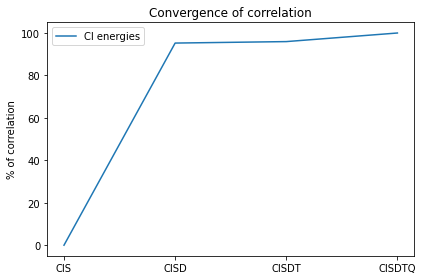

Percentage of electron correlation recovered:  [0.00000 95.14411 95.83734 99.87964]


In [24]:
import matplotlib.pyplot as plt

Energies=np.array(Energies) #Create a numpy array from the energies

plt.figure(figsize=(6,4))
x = np.array(range(1,5))
plt.plot(x,(Energies-E_hf)/(E_FCI-E_hf)*100, label='CI energies')
plt.title('Convergence of correlation')
plt.xticks([1, 2, 3, 4], ['CIS', 'CISD', 'CISDT', 'CISDTQ'])
plt.ylabel("% of correlation")
plt.legend()
plt.tight_layout(); plt.show()

print("Percentage of electron correlation recovered: ",(Energies-E_hf)/(E_FCI-E_hf)*100)

As we can see above, CIS does not recover any correlation (the optimized HF determinant does not interact with single excitations), and in general the odd excitation orders do not add much to the correlation energy. However, already with CISD, we recover more than 95% of the correlation energy, and that number rises to nearly 99.9% with CISDTQ. This is remarkable as water has 10 electrons, and thus up to 10 excitations are included in the full CI. Looking at the determinant count, CISD has only 1.141 determinants, compared to the 828.828 of full CI.

This clearly suggests using truncated schemes, and in particular CISD as a relatively efficient way to recover most of the correlation energy.

(sec:size-consistency)=
### Size-consistency

The main issue with those truncated CI methods is that as the system grows larger, the importance of higher excitations increase, and thus truncated CI capture a smaller and smaller fraction of the correlation. 

This is very well illustrated when taking two identical molecules at large distance. One would normally expect the energy of this non-interacting dimer to be exactly twice that of the monomer. Let's verify it on our water molecule:

In [25]:
del CIdrv #Unsure why I need to do this to not mess everything up

#Two water molecules, 100Å apart, CISD.
h2o_xyz = """6
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
O  100.000000000000        0.000000000000        0.000000000000                         
H  100.000000000000        0.740848095288        0.582094932012                         
H  100.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(molecule, "6-31G")

scfdrv = vlx.ScfRestrictedDriver()
scfdrv.compute(molecule, basis)

space=mtp.OrbSpace(molecule,scfdrv.mol_orbs)
space.CISD()

CIdrv=mtp.CIDriver(molecule,basis,space)
CIdrv.compute(1)

E_2h20=CIdrv.getEnergies()[0]

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [26]:
print("CI Energy of 2 water molecules",E_2h20)
print("Twice the energy of 1 water molecule",2*E_FCI)

CI Energy of 2 water molecules -152.21519321822962
Twice the energy of 1 water molecule -152.2375077759441


The calculation for the dimer found the energy to be higher than twice the monomer, and not equal as one would expect. This systematic failure of truncated CI is called size consistency error. In general, the truncated CI energy of two molecules far apart from each other is not the same as the sum of the truncated CI energy of each molecule.

To understand this, let's assume a molecule $A$ whose CI expansion consists only of 2 SD, the HF reference and a SD generated by exciting 2 electrons from orbitals $i, j$ to $a, b$:

\begin{equation}
| \Psi_A \rangle = c_{0} | ... ij ...\rangle + c_{ijab} | ... ab ...\rangle
\end{equation}

Now let's assume a second molecule $B$ with also 2 SD, the second one being generated from a $klcd$ excitation from the reference:

\begin{equation}
| \Psi_B \rangle = c'_{0} | ... kl ...\rangle + c'_{klcd} | ... cd ...\rangle
\end{equation}

In a correct calculation, since the two systems are far apart, they should be independent, and thus, their combined wavefunction can be expressed as a product of their individual ones:

\begin{eqnarray}
| \Psi_{AB} \rangle &= | \Psi_A \Psi B \rangle \\
                    &= (c_{0} | ... ij ...\rangle + c_{ijab} | ... ab ...\rangle)(c'_{0} | ... kl ...\rangle + c'_{klcd} | ... cd ...\rangle) \\
                    &= c_0 c'_0 | ... ij...kl ...\rangle + c_{0}c'_{klcd} | ... ij...cd ...\rangle + c_{ijab}c'_{0} | ... ab...kl ...\rangle + c_{ijab}c'_{klcd} | ... ab...cd ...\rangle   \\
\end{eqnarray}

The last term corresponds to a quadruple excitation from the first one (the HF reference). Since these quadruple excitations are excluded from CISD, it is clear the method cannot describe the combined system as well as it can describe the individual subsystems.

While some approximate corrections exist, truncated CI have for the most part disappeared from the quantum chemistry landscape as more efficient and/or more accurate methods supplanted them.